# Analyze A/B Test Results 


## Introduction

A/B tests are essential tools for data analysts and data scientists to evaluate the performance of different versions of a webpage or product. In this project, I performed an A/B test analysis using a dataset from an e-commerce website. The goal was to determine whether the company should implement a new webpage, keep the old one, or continue running the experiment to make a more informed decision.

The project was structured into several key sections:

- Probability: Understanding and calculating the probability of conversions.
- A/B Test: Setting up and analyzing the A/B test to compare the performance of the new and old webpages.
- Regression: Using regression analysis to further explore the relationship between various factors and conversion rates.

Each section involved specific tasks and statistical tests to ensure a thorough analysis of the data.


In [80]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

## Data Collection and Preparation

 I began by collecting the dataset, **e-commerce_data.csv**, which included the following columns:

- **user_id:**  Unique identifier for each user.
- **timestamp:**  The time when the user visited the webpage.
- **group:**  Indicates whether the user was in the control group (served with the old page) or the treatment group (served with the new page).
- **landing_page:**  Specifies whether the user landed on the old page or the new page.
- **converted:**  Indicates whether the user converted (1) or not (0).

In [81]:
df=pd.read_csv("e-commerce_data.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [82]:
# the number of rows
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


(294478, 5)

In [83]:
#number of unique users
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [84]:
#proportion of users converted
df["converted"].mean()

0.11965919355605512

In [85]:
#no of times when the "group" is `treatment` but "landing_page" is not a `new_page`
q=df.query('group == "treatment" & landing_page != "new_page"')
len(q)


1965

In [86]:
#finding rows have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [87]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df1= df.drop(df[(df['group']=="treatment")&(df['landing_page']!="new_page")].index)
df2= df1.drop(df1[(df1['group']=="control")&(df1['landing_page']!="old_page")].index)

In [88]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [89]:
#no of unique user_ids
a=df2['user_id'].unique()
len(a)

290584

In [90]:
# Finding the duplicates
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [91]:
# Remove one of the rows with a duplicate user_id..
# drop_duplicates() not used, because the rows with duplicate user_id are not entirely identical. 


df2.drop(labels=2893, inplace =True)


In [92]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


## Analysis and Results

### Part I - Probability:
I calculated the overall conversion probability across all users, regardless of the page they received. This provided a baseline for understanding the general conversion rate in the population.

In [93]:
# the probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959708724499628

In [94]:
# individual was in the `control` group,the probability they converted
df2.query("group == 'control'").converted.mean()

0.1203863045004612

In [95]:
#individual was in the `treatment` group, the probability they converted
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

In [96]:
#probability that an individual received the new page
x=df2.query('landing_page == "new_page"')
y=df2['landing_page']
len(x)/len(y)

0.5000619442226688

###### We cannot declare that the new treatment page leads to more conversions due to no sufficient evidence as the variation between the groups of treatment and control is minute and almost equal from the results obtained.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>> null hypothesis: pold>=pnew

>> Alternative hypothesis: pold< pnew

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

### Part II - A/B Test:

I conducted hypothesis testing to compare the conversion rates between the control group (old page) and the treatment group (new page). This involved setting up null and alternative hypotheses, calculating the p-value, and determining statistical significance.

In [97]:
### Calcualting the conversion rates for the Probabilites under null hypothesis

In [98]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

In [99]:
p_old=df2['converted'].mean()
p_old

0.11959708724499628

In [100]:
n_new=len(df2.query('landing_page =="new_page"'))
n_new

145310

In [101]:
n_old=len(df2.query('landing_page !="new_page"'))
n_old

145274

In [102]:
# Simulate a Sample for the treatment Group
# new_page_converted = np.random.binomial(1,p_new,n_new)

new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.12008120569816255

In [103]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()


0.11879620579043738

In [104]:
#Find the difference in the "converted" probability(g)
new_page_converted.mean() - old_page_converted.mean()

0.0012849999077251678

In [105]:
# Sampling distribution, Simulating a sample with the same size as the control and treatment group
# store all 10,000 values in p_diffs
p_diffs = []

for y in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    p_diffs.append(new_page_converted-old_page_converted)

Text(0.5, 1.0, 'Plot of 10,000 Simulated p_diffs')

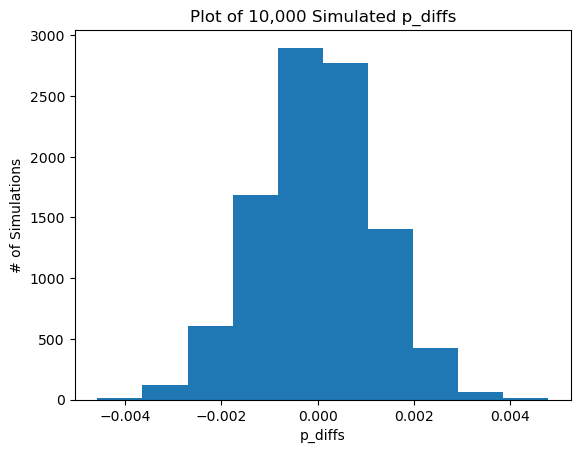

In [106]:
# Plotting histogram of the p_diffs
plt.hist(p_diffs)
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs')

Text(0, 0.5, 'frequency')

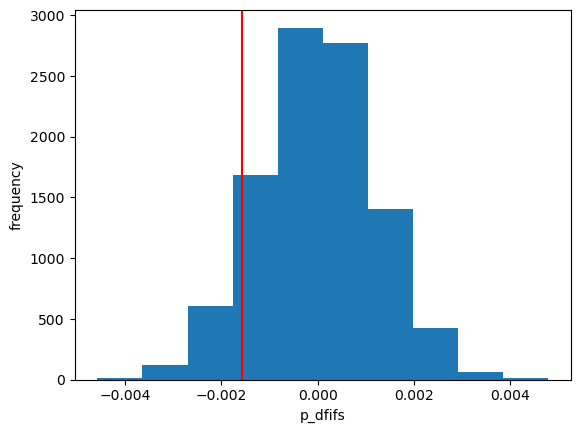

In [107]:
obs_diff = df2.query('group == "treatment"').converted.mean()-df2.query('group=="control"').converted.mean()
#a_diffs =( p_diffs.mean() + (p_diffs.mean() - obs_diff))
plt.hist(p_diffs)
plt.axvline(obs_diff, color= 'r')
#plt.axvline(a_diffs, color= 'r')
plt.xlabel("p_dfifs")
plt.ylabel("frequency")

In [108]:
actual_diff = (df2[df2['group'] == "treatment"]['converted'].mean()) - (df2[df2['group'] == "control"]['converted'].mean())
actual_diff

-0.0015782389853555567

In [109]:
(p_diffs < obs_diff).mean(),(p_diffs > obs_diff).mean()

(0.097, 0.903)

###### The given computed p-value is too high such that it suggests that we fail to reject the null-hypothesis.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [112]:
%pip install statsmodels


In [111]:
#calculate the number of conversions for each page, as well as the number of individuals who received each page.
# Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

import statsmodels.api as sm

# number of conversions with the old_page
convert_old =len(df2.query('landing_page == "old_page" & converted == 1'))

# number of conversions with the new_page
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page == "old_page"'))

# number of individuals who received new_page
n_new =len(df2.query('landing_page =="new_page"'))

convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

In [113]:
#compute your test statistic and p-value
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative = 'smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


###### The z-score computed in the previous question is not exceeded from the critical value and also the p-value computed is not varied from earlier so there is no evidence gathered to reject the null hypothesis but does include in highest rate of probability of being null hypothesis.

## Part III - Regression:

To further analyze the impact of different factors on conversion rates, I performed a logistic regression analysis. This helped identify whether factors such as the group assignment and other variables significantly influenced the likelihood of conversion.

In [114]:
df2["interecept"]=1
df2[['a_dum', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,interecept,a_dum,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,True,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,True,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,False,True
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,False,True
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,True,False


In [115]:
df2=df2.drop('a_dum',axis=1)

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [116]:
logit_mod = sm.Logit(df2['converted'], df2['ab_page'])

In [117]:
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.528825
         Iterations 6


In [118]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            0
Date:                Sun, 09 Jun 2024   Pseudo R-squ.:                 -0.4444
Time:                        12:10:32   Log-Likelihood:            -1.5367e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -2.0038      0.008   -247.146      0.000      -2.020      -1.988
==============================================================================
"""

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [132]:
# Read the countries.csv
c=pd.read_csv('countries.csv')
c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [ ]:
# Join with the df2 dataframe
df2=df2.set_index('user_id').join(c.set_index('user_id'))
# no error if we able to run once. if we ran it twice the keyword error pops

In [134]:
df2.head()

,timestamp,group,landing_page,converted,interecept,ab_page,intercept,country,UK,US,CA
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,False,1,US,False,False,True
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,False,1,US,False,False,True
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,True,1,US,False,False,True
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,True,1,US,False,False,True
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,False,1,US,False,False,True


In [141]:
df2[['CA', 'US']] = pd.get_dummies(df2['country'])[['CA','US']]
df2.head()

,timestamp,group,landing_page,converted,interecept,ab_page,intercept,country,UK,US,CA
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,False,1,US,False,True,False
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,False,1,US,False,True,False
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,True,1,US,False,True,False
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,True,1,US,False,True,False
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,False,1,US,False,True,False


In [ ]:
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['CA', 'US', 'interecept', 'ab_page']])
results = log_mod.fit()

In [58]:
df2.groupby(['country','ab_page'], as_index=False).mean()

,country,ab_page,converted,interecept,UK,US,CA,ab_page_ca,ab_page_uk,ab_page_us
0,CA,0,0.118783,1.0,1,0,0,0,0,0
1,CA,1,0.111902,1.0,1,0,0,0,1,0
2,UK,0,0.120022,1.0,0,1,0,0,0,0
3,UK,1,0.121171,1.0,0,1,0,0,0,1
4,US,0,0.120630,1.0,0,0,1,0,0,0
5,US,1,0.118466,1.0,0,0,1,1,0,0


In [104]:
df2['ab_page_ca'] = df2['CA']*df2['ab_page']
df2['ab_page_uk'] = df2['UK']*df2['ab_page']
df2['ab_page_us'] = df2['US']*df2['ab_page']

In [106]:
# Fit your model, and summarize the results
lm = sm.Logit(df2['converted'], df2[['interecept' ,'UK','CA','ab_page_us','ab_page_uk', 'ab_page_ca']])
x = lm.fit()
x.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-03-02 20:20 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
interecept   -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
UK           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
ab_page_us    0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
ab_page_uk   -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
ab_page_ca   -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
==================================================================

"""

the both the pvalues are grater than 0.005. so, there is no difference of between the Uk and Ca for the new landing page. the new page soesnt convert more than old page 

### Final Conclusion

On applying regression for the above values,It is observed that the p-value factor between US and Canada are varied highly where in the factor is high in US than Canada because of users likeliness to convert.But there is no complete evidence of the null hypothesis for it to be rejected.

On observation of the total analysis performance,it can be stated that the new page does not show much variation in the histogram and the old page is much better than the new page in accordance with the null hypothesis